In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import random

# For preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 

# For LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

# For FOPDT model
from scipy.integrate import odeint

# For hyperopt (parameter optimization)
# ! pip install hyperopt
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp

In [2]:
# Define functions to generate FOPDT model data
def fopdt(y,t,um,Km,taum):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate simple model with x=[Km,taum]
def sim_model(Km,taum):
    # array for model values
    ym = np.zeros(ns)
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(u[i],Km,taum))
        ym[i+1] = y1[-1]
    return ym

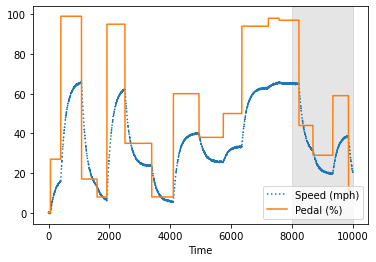

In [3]:
# Parameters and time for FOPDT model
ns = 10000
t = np.linspace(0,ns-1,ns)
u = np.zeros(ns)

# Additional FOPDT parameters
yp0 = 0.0
u0 = u[0]
Km = 0.67
taum = 160.0

# Generate step data for u
end = 60 # leave 1st minute of u as 0
while end <= ns:
    start = end
    end += random.randint(300,900) # keep new Q1s value for anywhere from 5 to 15 minutes
    u[start:end] = random.randint(0,100)

# Simulate FOPDT model
y = sim_model(Km,taum)

# Add Gaussian noise
noise = np.random.normal(0,0.2,ns)
y += noise

# Scale data
data = np.vstack((u,y)).T
s = MinMaxScaler(feature_range=(0,1))
data_s = s.fit_transform(data)

# Plot FOPDT model
plt.plot(y,':',label='Speed (mph)')
plt.plot(u,label='Pedal (%)')
plt.axvspan(ns-int(ns/5.0),ns,alpha=0.2,color='gray')
plt.xlabel('Time')
plt.legend();

In [4]:
def format_data(window=30):
    # arrange data to LSTM input and output with specified window
    X = []
    y = []
    for i in range(window,len(data_s)):
        X.append(data_s[i-window:i])
        y.append(data_s[i,1])
    
    # Format to array for LSTM input
    X, y = np.array(X), np.array(y)
    
    # Split into train and test
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,shuffle=False)        
    
    return Xtrain, ytrain, Xtest, ytest

In [5]:
def forecast(Xtest,ytest,model,window):
    Yr = ytest
    Yp = model.predict(Xtest)
    Yf = ytest.copy()
    for i in range(len(Yf)):
        if i < window:
            pass
        else:
            XQ = Xtest[i,:,0]
            XT = Yf[i-window:i]
            Xf = np.vstack((XQ,XT)).T
            Xf = np.reshape(Xf, (1, Xf.shape[0], Xf.shape[1])) 
            Yf[i] = model.predict(Xf)[0] 
            
    return Yr, Yp, Yf


In [6]:
from hyperopt.pyll.base import scope #quniform returns float, some parameters require int; use this to force int

space = {'rate'       : hp.uniform('rate',0.01,0.5),
         'units'      : scope.int(hp.quniform('units',10,100,5)),
         'batch_size' : scope.int(hp.quniform('batch_size',100,250,25)),
         'layers'     : scope.int(hp.quniform('layers',1,6,1)),
         'window'     : scope.int(hp.quniform('window',10,50,5))
        }

In [7]:
def f_nn(params):
    # Generate data with given window
    Xtrain, ytrain, Xtest, ytest = format_data(window=params['window'])
    
    # Keras LSTM model
    model = Sequential()
    
    if params['layers'] == 1:
        model.add(LSTM(units=params['units'], input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
        model.add(Dropout(rate=params['rate']))
    else:
        # First layer specifies input_shape and returns sequences
        model.add(LSTM(units=params['units'], return_sequences=True, input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
        model.add(Dropout(rate=params['rate']))
        # Middle layers return sequences
        for i in range(params['layers']-2):
            model.add(LSTM(units=params['units'],return_sequences=True))
            model.add(Dropout(rate=params['rate']))
        # Last layer doesn't return anything
        model.add(LSTM(units=params['units']))
        model.add(Dropout(rate=params['rate']))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=15)

    result = model.fit(Xtrain, ytrain, verbose=0, validation_split=0.1,
                       batch_size=params['batch_size'],
                       epochs=200,
                       callbacks = [es,TqdmCallback(verbose=1)]
                      )
    
    #get the lowest validation loss of the training epochs
    validation_loss = np.amin(result.history['val_loss']) 
#     print('Best validation loss of epoch:', validation_loss)
    val_length = int(0.2*len(ytest))
    Xval, yval = Xtrain[-val_length:], ytrain[-val_length:]
    
    # Evaluate forecast
    Yr, Yp, Yf = forecast(Xval,yval,model,params['window'])
    mse = np.mean((Yr - Yf)**2)
    print('Best forecast loss of epoch:', mse)
    
    return {'loss': mse, 'status': STATUS_OK, 'model': model, 'params': params}

In [8]:
trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)

best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']

worst_model = trials.results[np.argmax([r['loss'] for r in trials.results])]['model']
worst_params = trials.results[np.argmax([r['loss'] for r in trials.results])]['params']

Best forecast loss of epoch:                                                                  
0.0037929362942308274                                                                         
Best forecast loss of epoch:                                                                  
0.00013896756869821698                                                                        
Best forecast loss of epoch:                                                                  
0.0009813922499425953                                                                         
Best forecast loss of epoch:                                                                  
0.04824185545737728                                                                           
Best forecast loss of epoch:                                                                  
0.00011055744901651366                                                                        
Best forecast loss of epoch:                      

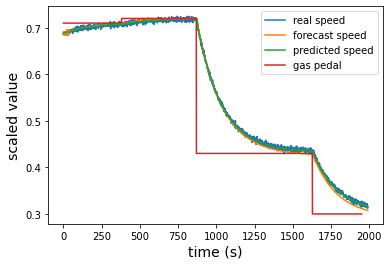

In [26]:
# Best window
best_window = best_params['window']

# Format data
Xtrain, ytrain, Xtest, ytest = format_data(window=best_window)
Yr, Yp, Yf = forecast(Xtest,ytest,best_model,best_window)
        
plt.plot(Yr,label='real speed')
plt.plot(Yf,label='forecast speed')
plt.plot(Yp,label='predicted speed')
plt.plot(Xtest[best_window:,0,0],label='gas pedal')
plt.ylabel('scaled value',size=14)
plt.xlabel('time (s)',size=14)
plt.legend()

# Worst model results

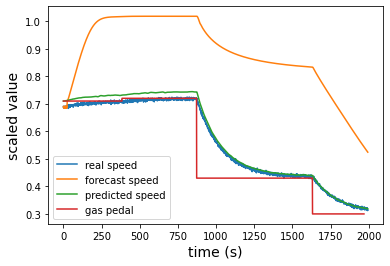

In [25]:
worst_window = worst_params['window']
Xtrain, ytrain, Xtest, ytest = format_data(window=worst_window)
Yr, Yp, Yf = forecast(Xtest,ytest,worst_model,worst_window)
        
plt.plot(Yr,label='real speed')
plt.plot(Yf,label='forecast speed')
plt.plot(Yp,label='predicted speed')
plt.plot(Xtest[worst_window:,0,0],label='gas pedal')
plt.ylabel('scaled value',size=14)
plt.xlabel('time (s)',size=14)
plt.legend()